In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pandas import to_datetime

In [2]:
savename='timeseries_windDir'

In [3]:
# Global path = "/global/scratch/users/adac/Slope_Flow/SlopeFlow/WRFV3/LES3/"
# Template file = "wrfout_d01_2014-03-21_12:00:00"

path = "../WRFV3/LES3"
file= "wrfout_d01_2014-03-21_12:00:00"

ds = xr.open_dataset(path+'/'+file)#+'.nc')
ds

<xarray.Dataset>
Dimensions:                (Time: 121, south_north: 149, west_east: 399,
                            bottom_top: 68, bottom_top_stag: 69,
                            soil_layers_stag: 4, west_east_stag: 400,
                            south_north_stag: 150)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/153)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/119)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2014-03-21_12:00:00
    SIMULATION_START_DATE:           2014-03-21_12:00:00
    WEST-EAST_GRID_DIMENSION:        400
    SOUTH-NORTH_GRID_DIMENSION:      150
    BOTTOM-TOP_GRID_DIMENSION:       69
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      -1
    ETAC:                            0.0

In [4]:
timesStr = [bytestring.decode('utf-8') for bytestring in ds['Times'].values]
# timesStr = [bytestring.decode('utf-8') for bytestring in ds['Times'][1:].values]
times = to_datetime(timesStr, format='%Y-%m-%d_%H:%M:%S')
nt = len(times)
dt = 10/60 # 10 min/(60 min/hr) = dt [hrs] 
tv = np.arange(0,nt*dt,dt).T + 12 # starts 12
tv.shape

(121,)

In [5]:
nx = ds.dims["west_east"]
dx = ds.attrs['DX']
xmid = nx/2*dx

In [6]:
L1 = 3000.
L2 = 1000.
xplot = [ xmid - L2/2 - dx/2, xmid - L2 - L1/2 - dx/2, xmid + L2/2 + dx/2, xmid + L2 + L1/2 + dx/2]

In [7]:
xuv = np.arange(0,nx*dx,dx)
ixs = [np.where(xuv == xp)[0][0] for xp in xplot]

In [8]:
u = ds['U'][:,0,:,ixs]
# u = ds['U'][1:,0,:,ixs]
print(u.shape)
ivs = [ix - 1 for ix in ixs]
v = 0.25 * (ds['V'][:,0,1:,ivs] + ds['V'][:,0,1:,ixs] + ds['V'][:,0,:-1,ivs] + ds['V'][:,0,:-1,ixs])
# v = 0.25 * (ds['V'][1:,0,1:,ivs] + ds['V'][1:,0,1:,ixs] + ds['V'][1:,0,:-1,ivs] + ds['V'][1:,0,:-1,ixs])

(121, 149, 4)


In [9]:
wspd = np.sqrt(u.values**2 + v.values**2)
unorm = u.values / wspd
vnorm = v.values / wspd
ubar = unorm.mean(axis=1)
vbar = vnorm.mean(axis=1)

/tmp/ipykernel_421091/2579820667.py:2: RuntimeWarning: invalid value encountered in divide
  unorm = u.values / wspd
/tmp/ipykernel_421091/2579820667.py:3: RuntimeWarning: invalid value encountered in divide
  vnorm = v.values / wspd


In [10]:
wdir = (270.0 - np.degrees(np.arctan2(vbar, ubar))) % 360.0
wdir.shape

(121, 4)

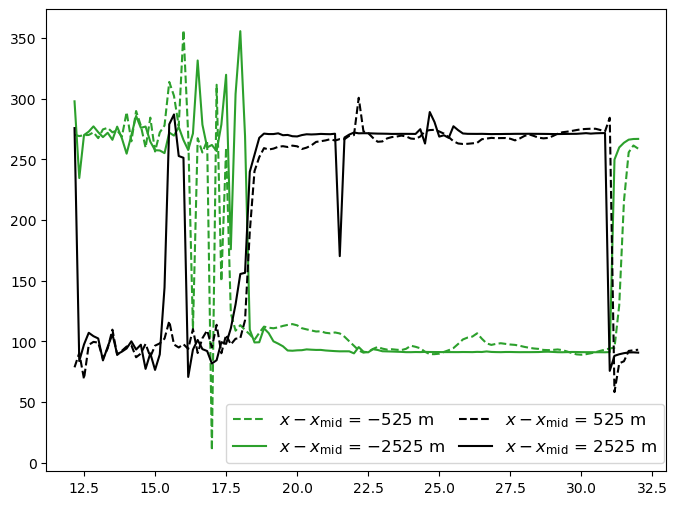

In [11]:
# fig, axs = plt.subplots( 1, 2, figsize=(12, 4) ) #panel with wind dir plot?
try:
    del(fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots( 1, 1, figsize=(8, 6) )
except:
    fig, axs = plt.subplots( 1, 1, figsize=(8, 6) )

colors = ['tab:green','k']
styles = ['--','-','--','-']
vmin = 0
vmax = 360

for i,xp in enumerate(xplot):

    plot = axs.plot( tv, wdir[:,i], label=r'$x - x_{\text{mid}}$ = '+fr"${int(xp-xmid)}$"+' m',
                                  color=colors[i//2],
                                  linestyle=styles[i],
                                   )
axs.legend(ncol=2, columnspacing=0.8, fontsize=12,loc='lower right',bbox_to_anchor=(1.01, 0))

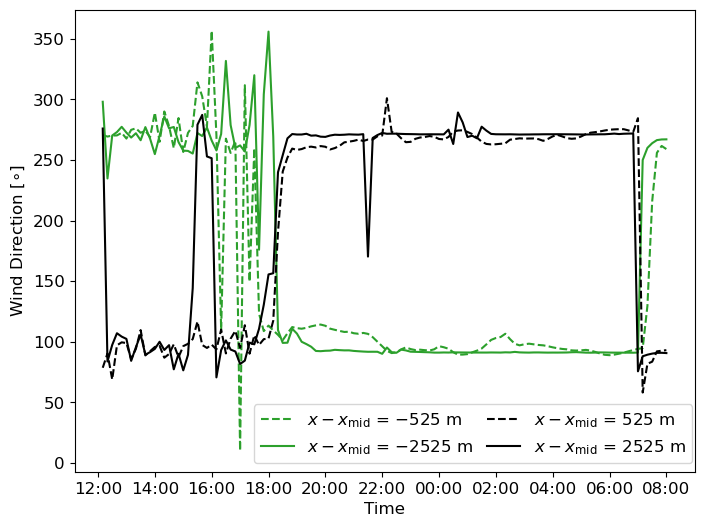

In [12]:
axs.set_xticks(tv[::12])
axs.set_xticklabels(times[::12].strftime('%H:%M'), rotation=0)
axs.tick_params(labelsize=12)
axs.set_xlabel('Time',size=12)
axs.set_ylabel(r'Wind Direction [$\circ$]',size=12)
fig

In [13]:
save=True
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("plots/"+savename+"."+fmt, format=fmt)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
